In [1]:
import torch
from PIL import Image
import mobileclip
from torchsummary import summary

from mobileclip.clip import CLIP
from mobileclip.text_encoder import TextTransformer
import os
from pathlib import Path

import onnxruntime as ort

from PIL import Image

d:\Users\Grey\miniconda3\envs\mobileclip\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Users\Grey\miniconda3\envs\mobileclip\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
model_text = "mobileclip-text-encoder.onnx"
# model_text = "text_model.onnx"
model_image = "mobileclip-image-encoder.onnx"

model, _, preprocess = mobileclip.create_model_and_transforms(
    "mobileclip_s0", pretrained="./models/mobileclip_s0.pt"
)

d:\Develop\Projects\Python\ml-mobileclip\mobileclip\__init__.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chkpt = torch.load(pretrained)


Text Encoder

In [3]:
# sess_opt = ort.SessionOptions()
# sess_opt.log_severity_level = 0  # Verbose
text_session = ort.InferenceSession(model_text)

In [4]:
text = "A Diagram"
tokenizer = mobileclip.get_tokenizer("mobileclip_s0")
token_input: torch.Tensor = tokenizer(text)
token_input = token_input.to(torch.int32)
input_name = text_session.get_inputs()[0].name
outputs = text_session.run(None, {input_name: token_input.numpy()})
print(f"text: '{text}' feat:", outputs[0])

text: 'A Diagram' feat: [[ 3.26862037e-02  1.28375053e-01 -4.30430055e-01  1.46925494e-01
   5.24902344e-02 -2.03687549e-02  1.03805530e+00  1.77096725e-01
  -1.66373029e-01 -1.93358332e-01 -1.99873537e-01 -2.08314255e-01
   2.38581657e-01 -1.43348679e-01 -1.05593346e-01 -2.03171819e-01
   1.15079534e+00 -6.50460348e-02  7.39444792e-02 -1.60057589e-01
   3.89059335e-02 -6.85897097e-02  1.48070261e-01  7.41277486e-02
   4.36763465e-03  3.02056879e-01 -4.35632877e-02 -6.94985032e-01
  -2.88875043e-01 -4.57690507e-01  1.15439631e-01  8.18562508e-03
   3.97044927e-01  2.71156996e-01  1.61107197e-01 -1.17703885e-01
   6.43585622e-02  2.49375403e-01  1.04696468e-01  3.53549093e-01
  -1.10464320e-01 -3.15328240e-01 -3.42263192e-01  2.08544016e-01
   1.15518756e-01  3.04144531e-01 -3.26300383e-01  1.23253703e-01
   2.41317898e-01 -4.21864316e-02  2.21061409e-02  7.18864202e-02
  -1.02803513e-01 -7.69165576e-01 -2.08721370e-01  2.15229765e-01
  -2.98898742e-02 -1.08047053e-01  2.30706409e-01 -5

Image Encoder


In [5]:
# Load Image model
image_path = "docs/example.png"
image_session = ort.InferenceSession(model_image)


Inspect image input format

<PIL.Image.Image image mode=RGB size=256x256 at 0x19866705A20>


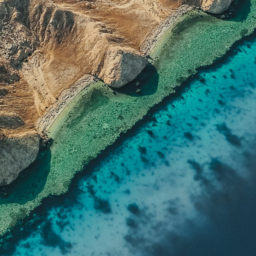

In [6]:
import torchvision.transforms.functional as F

pil = Image.open(image_path)
pil = F.resize(pil, [256, 256])

pil = pil.convert("RGB")
print(pil)
pil

In [7]:
from torch import Tensor

image_input = preprocess(pil)
# print("image_input dim:\n", image_input.shape)

# print("image_input:\n", image_input)

converted_rgb_pil = pil.convert("RGB")

image_input: Tensor = preprocess(converted_rgb_pil)
# print("converted_rgb image_input dim:\n", image_input.shape)
# print("converted_rgb image_input:\n", image_input)

# 模型的输入格式原先就是为了批量执行设计的。
# 因此哪怕一张图也要需要增加一个维度，实际上可以放入多个图片批量推理
image_input = image_input.unsqueeze(0) # add batch dimension 

print("image_input.dtype", image_input.dtype)

image_input.dtype torch.float32


In [49]:
# export tensor to a file
flatten_tensor = image_input.flatten()
print("image_input:\n", flatten_tensor)
py_list = flatten_tensor.tolist()
with open("ExampleFloatArray.kt", "w") as f:
    f.write("package me.grey.picquery.domain\n")
    f.write("val exampleFloatArray = floatArrayOf(\n")
    f.write(", \n".join([f"{x:.4f}f" for x in py_list]))
    f.write(")")

image_input:
 tensor([0.8000, 0.8353, 0.8275,  ..., 0.2824, 0.2824, 0.2824])


Inference with image encoder

In [20]:
import numpy as np

dummy_output = image_session.run(None, {input_name: image_input.numpy()})

print(f"dummy_output for all zeros' feat:", outputs[0])

# outputs = image_session.run(None, {input_name: image_input.numpy()})

# print(f"image '{image_path}' feat:", outputs[0])

dummy_output for all zeros' feat: [[ 3.26862037e-02  1.28375053e-01 -4.30430055e-01  1.46925494e-01
   5.24902344e-02 -2.03687549e-02  1.03805530e+00  1.77096725e-01
  -1.66373029e-01 -1.93358332e-01 -1.99873537e-01 -2.08314255e-01
   2.38581657e-01 -1.43348679e-01 -1.05593346e-01 -2.03171819e-01
   1.15079534e+00 -6.50460348e-02  7.39444792e-02 -1.60057589e-01
   3.89059335e-02 -6.85897097e-02  1.48070261e-01  7.41277486e-02
   4.36763465e-03  3.02056879e-01 -4.35632877e-02 -6.94985032e-01
  -2.88875043e-01 -4.57690507e-01  1.15439631e-01  8.18562508e-03
   3.97044927e-01  2.71156996e-01  1.61107197e-01 -1.17703885e-01
   6.43585622e-02  2.49375403e-01  1.04696468e-01  3.53549093e-01
  -1.10464320e-01 -3.15328240e-01 -3.42263192e-01  2.08544016e-01
   1.15518756e-01  3.04144531e-01 -3.26300383e-01  1.23253703e-01
   2.41317898e-01 -4.21864316e-02  2.21061409e-02  7.18864202e-02
  -1.02803513e-01 -7.69165576e-01 -2.08721370e-01  2.15229765e-01
  -2.98898742e-02 -1.08047053e-01  2.30706

In [22]:
# Support batch

import onnx

mp = onnx.load_model(model_image)
model_image_batch = f'{model_image}_batch.onnx'
mp.graph.input[0].type.tensor_type.shape.dim[0].dim_param = 'None'
onnx.save(mp, model_image_batch)

image_batch_session = ort.InferenceSession(model_image_batch)
input_name = image_batch_session.get_inputs()[0].name

dummy_input = torch.zeros(3, 256, 256)
batch_dummy_input = torch.tensor(np.stack([dummy_input, dummy_input, dummy_input]))

image_batch_session.run(None, {input_name: batch_dummy_input.numpy()})

RuntimeException: [ONNXRuntimeError] : 6 : RUNTIME_EXCEPTION : Non-zero status code returned while running Reshape node. Name:'/model/network.7/network.7.0/token_mixer/Reshape_1' Status Message: D:\a\_work\1\s\onnxruntime\core\providers\cpu\tensor\reshape_helper.h:47 onnxruntime::ReshapeHelper::ReshapeHelper input_shape_size == size was false. The input tensor cannot be reshaped to the requested shape. Input shape:{3,64,1536}, requested shape:{1,64,3,16,32}


In [ ]:
# with torch.no_grad(), torch.cuda.amp.autocast():
#     image_features = model.encode_image(image)
#     text_features = model.encode_text(text)

#     print("image_features:", image_features)
#     print("text_features:", text_features)
#     image_features /= image_features.norm(dim=-1, keepdim=True)
#     text_features /= text_features.norm(dim=-1, keepdim=True)

#     text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

# print("Label probs:", text_probs)